# Matriz Moran Brasil

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/matriz_moran_brasil.ipynb`

## Bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

Requirement already up-to-date: pyshp in /home/walef/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: descartes in /home/walef/anaconda3/lib/python3.7/site-packages (1.1.0)


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv',
                      encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

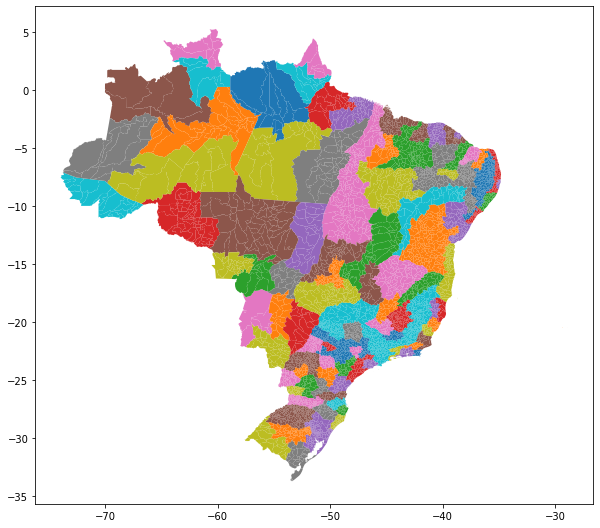

In [21]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Matriz de I de Moran 

Teste de construção de uma matriz de I de Moran para cada variável


### Criando a matriz

In [22]:
moran_matrix = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
moran_matrix = moran_matrix.drop(retirar, axis = 1)

### I de Moran local para variáveis

In [23]:
moran_matrix.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [24]:
# demora um pouco
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [25]:
for variavel in moran_matrix.drop(['nome_mun', 'geometry'], axis = 1).columns:
    moran_matrix[variavel] = Moran_Local(dados_br[variavel].values, w).Is

In [26]:
moran_matrix = moran_matrix.set_index('nome_mun')

In [27]:
moran_matrix.describe()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
count,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000
mean,0.526489,0.414461,0.358168,0.363137,0.457272,0.588949,0.694188,0.504681
std,4.101609,2.670645,2.963947,2.965074,7.593469,2.877652,3.057223,7.605073
min,-3.459365,-3.555673,-2.449624,-2.250372,-1.963987,-2.334853,-3.374856,-2.706206
25%,0.034562,0.035359,0.030288,0.029972,0.026029,0.052482,0.050185,0.023832
50%,0.072723,0.080195,0.058180,0.058086,0.035857,0.104540,0.139668,0.033087
75%,0.076697,0.084188,0.060024,0.060018,0.035857,0.104540,0.148247,0.033087
max,138.070704,56.222827,98.399306,101.967140,367.286525,64.088046,47.902624,371.646238


### Mapa I de Moran

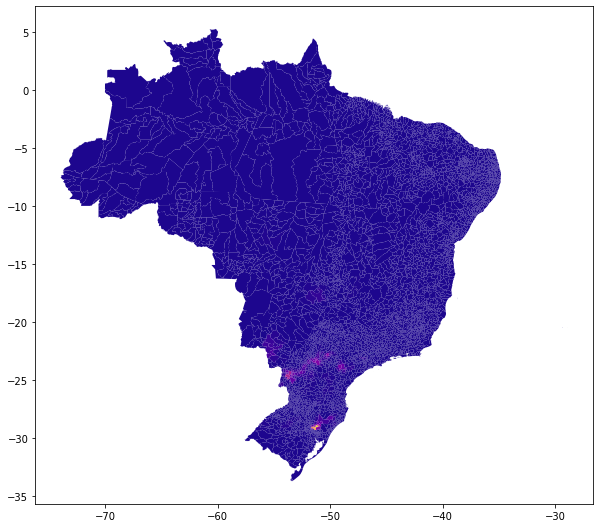

In [28]:
moran_matrix.plot(column='apolices_contratadas', figsize=(10, 10), cmap = 'plasma'); # , cmap='OrRd'

## Análise de agrupamento - I de Moran

In [29]:
# subselecionar variáveis
X = moran_matrix.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [30]:
Z = linkage(X, method='ward')

In [31]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

In [32]:
import sys
print(sys.getrecursionlimit())
# sys.setrecursionlimit(2000)

3000


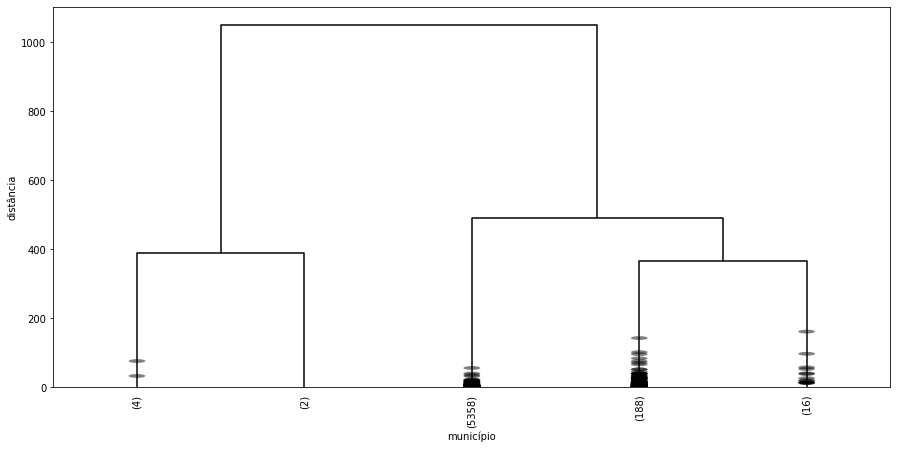

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [34]:
Z = linkage(X, method='ward')

In [35]:
# definir a distância de corte baseando no dendrograma
max_d = 250
grupos = cut_tree(Z, height=max_d)

### Métricas

In [36]:
#retirar = ['uf', 'nome_uf', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
#       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',] # 
#dados_metrics = dados_br.drop(retirar, axis = 1)
dados_metrics = moran_matrix.drop('geometry', axis=1)

In [37]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

7149.81 0.78 0.93


In [38]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
moran_matrix['grupo'] = grupos
# moran_matrix.head(2)

In [39]:
# contagem de observações em cada grupo
moran_matrix.grupo.value_counts()

0    5358
1     188
2      16
3       4
4       2
Name: grupo, dtype: int64

In [40]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,0.085529,0.124320,0.078774,0.077675,0.062703,0.165214,0.198209,0.038799
1,8.004665,5.249004,4.303148,4.448101,3.839298,11.159942,13.547393,5.648517
2,30.146854,34.263631,42.136610,41.920090,16.021574,8.338530,12.244659,19.442346
3,74.268232,16.373480,13.512872,15.001268,141.088521,14.926464,8.935453,160.150617
4,94.463457,20.545592,17.491700,19.397588,333.821043,51.427997,12.335954,294.288232


In [41]:
# mediana das variáveis para cada grupo
moran_matrix.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,0.070735,0.078874,0.057466,0.057313,0.035857,0.104540,0.137001,0.033087
1,5.465454,2.933595,2.967685,3.062950,1.899877,10.200864,11.982018,3.285468
2,21.374527,34.247445,35.720363,36.736792,15.408389,5.927906,9.122321,5.561850
3,75.457274,16.764815,13.609533,15.106310,137.915761,12.162157,8.188673,152.254001
4,94.463457,20.545592,17.491700,19.397588,333.821043,51.427997,12.335954,294.288232


### As observações de cada grupo


In [42]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran

In [43]:
moran_matrix['grupo'] = moran_matrix['grupo'].astype('category')

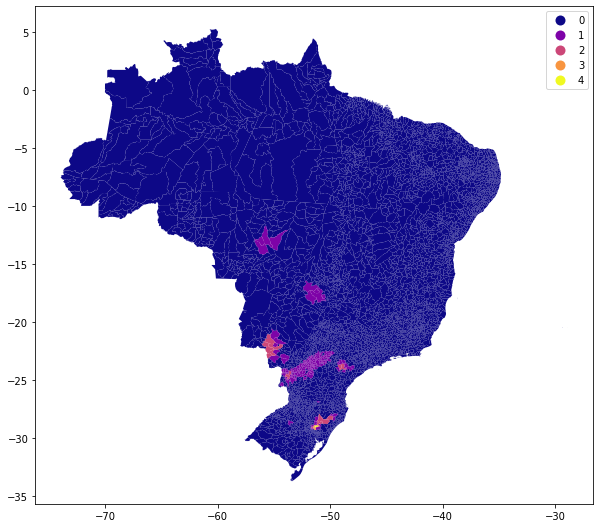

In [44]:
moran_matrix.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias - I de Moran


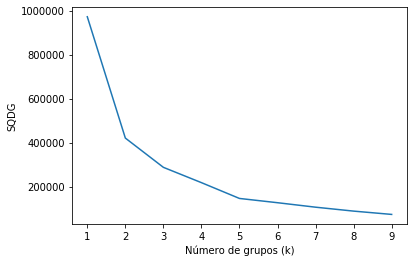

In [45]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(moran_matrix.drop('geometry', axis=1))
    moran_matrix['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [46]:
k = 5

In [47]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [48]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

7825.85 0.67 0.94


In [49]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
moran_matrix['grupo'] = kmeans.labels_

In [50]:
# contagens
moran_matrix.grupo.value_counts()

0    5420
3     127
4      14
2       5
1       2
Name: grupo, dtype: int64

In [52]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,0.123769,0.177009,0.110698,0.108584,0.074296,0.211906,0.289866,0.053297,0.041513
1,94.463457,20.545592,17.491700,19.397588,333.821043,51.427997,12.335954,294.288232,4.000000
2,79.808580,18.011640,13.737993,15.250204,123.044075,12.374896,7.802955,147.076555,2.200000
3,11.508287,5.602952,4.864255,5.108911,5.549136,14.817383,16.576795,8.917169,4.047244
4,15.081702,36.114870,48.061683,47.824612,11.128796,6.014148,8.944830,4.625204,4.857143


In [53]:
# mediana das variáveis para cada grupo
moran_matrix.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,0.071928,0.079291,0.057642,0.057522,0.035857,0.104540,0.137970,0.033087,0
1,94.463457,20.545592,17.491700,19.397588,333.821043,51.427997,12.335954,294.288232,4
2,81.022871,21.808463,14.638478,16.245948,137.838033,8.114776,6.931200,150.432289,1
3,8.114706,3.573633,4.056965,4.242639,3.213644,14.064356,15.281595,5.795227,4
4,12.868058,37.363125,38.458857,39.194459,7.677476,5.634820,7.127377,3.544435,4


In [54]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran

In [55]:
moran_matrix['grupo'] = moran_matrix['grupo'].astype('category')

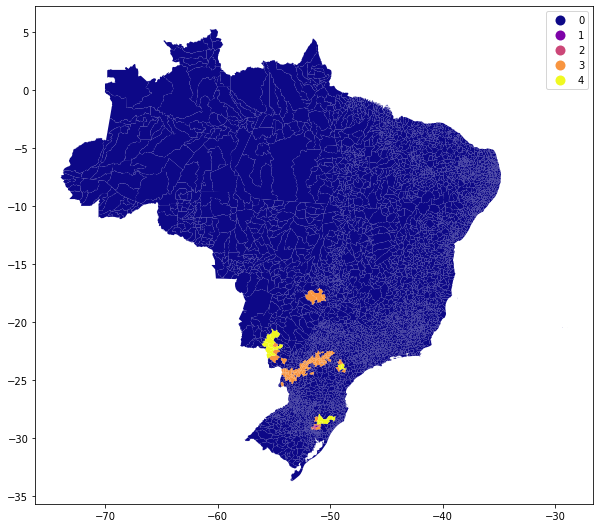

In [56]:
moran_matrix.plot(column='grupo', figsize=(10, 10), legend=True, cmap = 'plasma'); # , cmap='OrRd'